In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
eur = pd.read_excel('eur2017_hours.xls', index_col = [0, 1])
print(eur.head())

                       Close
Date       Time             
2017-01-01 22:00:00  64.3460
           23:00:00  64.3580
2017-01-02 00:00:00  64.3610
           01:00:00  64.7335
           02:00:00  64.7369


In [3]:
# Initialize the short and long windows
short_window = 100
long_window = 250

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=eur.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = eur['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = eur['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals.tail())

                     signal  short_mavg  long_mavg  positions
Date       Time                                              
2017-12-29 23:00:00     0.0   68.700055  69.031028        0.0
2017-12-30 00:00:00     0.0   68.704635  69.031204        0.0
           01:00:00     0.0   68.707667  69.031128        0.0
           02:00:00     0.0   68.711927  69.031400        0.0
2017-12-31 22:00:00     0.0   68.715757  69.031664        0.0


In [4]:
# Set the initial capital
initial_capital= float(10000.0)

# Create a DataFrame `portfolio`
portfolio = pd.DataFrame(index=signals.index).fillna(0.0)

portfolio['eur'] = eur['Close']
portfolio['positions'] = signals['positions']

portfolio['holdings'] = [0 for x in range(len(portfolio))]
portfolio['cash'] = [0 for x in range(len(portfolio))]

portfolio['cash'].iloc[0] = initial_capital

#Buy or sell when the positions are generated
for i in range(len(portfolio)):
    if i!=0:
        portfolio['cash'].iloc[i] = portfolio['cash'].iloc[i-1]
        portfolio['holdings'].iloc[i] = portfolio['holdings'].iloc[i-1]
    
    cash = portfolio['cash'].iloc[i]
    eur = portfolio['eur'].iloc[i]
    positions = portfolio['positions'].iloc[i]
    holdings = portfolio['holdings'].iloc[i]
    
    if positions == 1:
        holdings += cash/eur
        cash = 0
    if positions == -1:
        cash += holdings*eur
        holdings = 0
        
    portfolio['cash'].iloc[i] = cash
    portfolio['holdings'].iloc[i] = holdings
    
# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']*portfolio['eur']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total']/initial_capital-1
portfolio.drop(['eur'], axis=1)
# Print the first lines of `portfolio`
print(portfolio.tail())

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


                         eur  positions  holdings          cash         total  \
Date       Time                                                                 
2017-12-29 23:00:00  69.1950        0.0       0.0  10246.016114  10246.016114   
2017-12-30 00:00:00  69.2920        0.0       0.0  10246.016114  10246.016114   
           01:00:00  69.1582        0.0       0.0  10246.016114  10246.016114   
           02:00:00  69.1890        0.0       0.0  10246.016114  10246.016114   
2017-12-31 22:00:00  69.2100        0.0       0.0  10246.016114  10246.016114   

                      returns  
Date       Time                
2017-12-29 23:00:00  0.024602  
2017-12-30 00:00:00  0.024602  
           01:00:00  0.024602  
           02:00:00  0.024602  
2017-12-31 22:00:00  0.024602  


In [19]:
portfolio.to_excel('portfolio.xlsx')

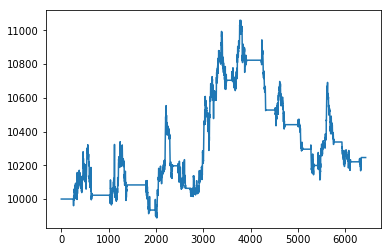

In [5]:
a=[]
for i in range(len(portfolio)):
    a.append(portfolio['total'].iloc[i])
plt.plot(a)
plt.show()

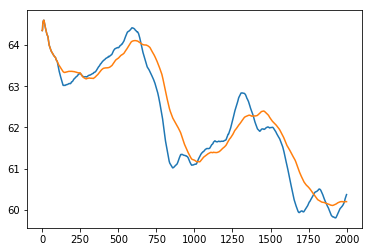

In [6]:
short = []
long = []
for i in range(2000):
    short.append(signals['short_mavg'].iloc[i])
    long.append(signals['long_mavg'].iloc[i])
plt.plot(short)
plt.plot(long)
plt.show()